## Setup imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
# #dsable eaager mode for tf 1.x
# tf.compat.v1.disable_eager_execution()

## Load the dataset and visualize the data

We use the `keras.datasets.mnist.load_data()` utility to directly pull the MNIST dataset
in the form of `NumPy` arrays. We then arrange it in the form of the train and test
splits.

Following loading the dataset, we select 4 random samples from within the training set
and visualize them using `matplotlib.pyplot`.

4 Random Training samples and labels


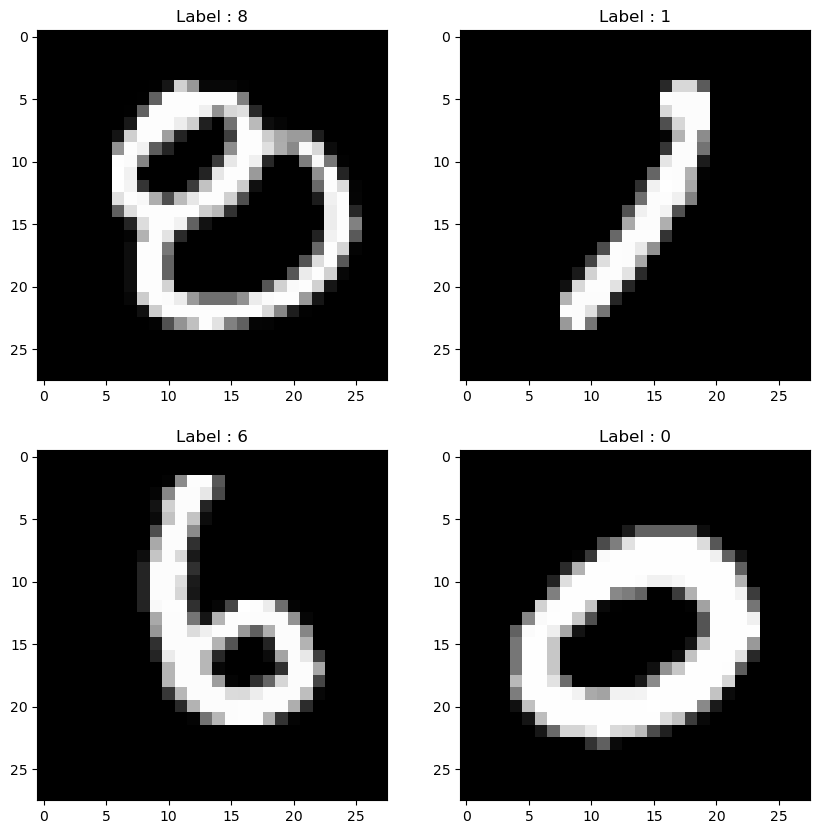

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

## Define `FFDense` custom layer

In this custom layer, we have a base `keras.layers.Dense` object which acts as the
base `Dense` layer within. Since weight updates will happen within the layer itself, we
add an `keras.optimizers.Optimizer` object that is accepted from the user. Here, we
use `Adam` as our optimizer with a rather higher learning rate of `0.03`.

Following the algorithm's specifics, we must set a `threshold` parameter that will be
used to make the positive-negative decision in each prediction. This is set to a default
of 2.0.
As the epochs are localized to the layer itself, we also set a `num_epochs` parameter
(defaults to 50).

We override the `call` method in order to perform a normalization over the complete
input space followed by running it through the base `Dense` layer as would happen in a
normal `Dense` layer call.

We implement the Forward-Forward algorithm which accepts 2 kinds of input tensors, each
representing the positive and negative samples respectively. We write a custom training
loop here with the use of `tf.GradientTape()`, within which we calculate a loss per
sample by taking the distance of the prediction from the threshold to understand the
error and taking its mean to get a `mean_loss` metric.

With the help of `tf.GradientTape()` we calculate the gradient updates for the trainable
base `Dense` layer and apply them using the layer's local optimizer.

Finally, we return the `call` result as the `Dense` results of the positive and negative
samples while also returning the last `mean_loss` metric and all the loss values over a
certain all-epoch run.

In [3]:

class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    # We perform a normalization step before we run the input through the Dense
    # layer.

    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)

    def forward_forward(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )


In [4]:

class FFNetwork(keras.Model):
    """
    A `keras.Model` that supports a `FFDense` network creation. This model
    can work for any kind of classification task. It has an internal
    implementation with some details specific to the MNIST dataset which can be
    changed as per the use-case.
    """

    # Since each layer runs gradient-calculation and optimization locally, each
    # layer has its own optimizer that we pass. As a standard choice, we pass
    # the `Adam` optimizer with a default learning rate of 0.03 as that was
    # found to be the best rate after experimentation.
    # Loss is tracked using `loss_var` and `loss_count` variables.
    # Use legacy optimizer for Layer Optimizer to fix issue
    # https://github.com/keras-team/keras-io/issues/1241

    def __init__(
        self,
        dims,
        layer_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.03),
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(len(dims) - 1):
            self.layer_list += [
                FFDense(
                    dims[d + 1],
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]

    # This function makes a dynamic change to the image wherein the labels are
    # put on top of the original image (for this example, as MNIST has 10
    # unique labels, we take the top-left corner's first 10 pixels). This
    # function returns the original data tensor with the first 10 pixels being
    # a pixel-based one-hot representation of the labels.

    @tf.function(reduce_retracing=True)
    def add_one_hot_label(self,data):
        num_classes = 10
        X_sample, y_sample = data
        label = tf.one_hot(y_sample, num_classes) 
        # first create a black image of the same size as the input image
        black_image = tf.zeros_like(X_sample,dtype=np.float32)
        # then add the one hot label to the black image
        label = tf.expand_dims(label, axis=-1)
        label = label.numpy()

        # change the first pixels of the black image to the put the label
        for i in range(label.shape[0]):
            black_image[0,i] = label[i][i]

        X_sample = tf.stack([X_sample, black_image], axis=2)

        return X_sample, y_sample

    # A custom `predict_one_sample` performs predictions by passing the images
    # through the network, measures the results produced by each layer (i.e.
    # how high/low the output values are with respect to the set threshold for
    # each label) and then simply finding the label with the highest values.
    # In such a case, the images are tested for their 'goodness' with all
    # labels.

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        for label in range(10):
            h, label = self.add_one_hot_label(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data
        print(f"Shape of x is {x.shape}")
        print(f"Shape of y is {y.shape}")
        # Flatten op
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])
        print(f"Shape of x is {x.shape}")
        x_pos, y = tf.map_fn(fn=self.add_one_hot_label, elems=(x, y))

        random_y = tf.random.shuffle(y)
        x_neg, y = tf.map_fn(fn=self.add_one_hot_label, elems=(x, random_y))

        h_pos, h_neg = x_pos, x_neg

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}


## Convert MNIST `NumPy` arrays to `tf.data.Dataset`

We now perform some preliminary processing on the `NumPy` arrays and then convert them
into the `tf.data.Dataset` format which allows for optimized loading.

In [5]:
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

## Fit the network and visualize results

Having performed all previous set-up, we are now going to run `model.fit()` and run 250
model epochs, which will perform 50*250 epochs on each layer. We get to see the plotted loss
curve as each layer is trained.

In [6]:
model = FFNetwork(dims=[784, 2, 2])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss="mse",
    #jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 2
history = model.fit(train_dataset, epochs=epochs)

Epoch 1/2
Shape of x is (None, 28, 28)
Shape of y is (None,)
Shape of x is (None, 784)


AttributeError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_122/4228725433.py", line 101, in train_step  *
        x_pos, y = tf.map_fn(fn=self.add_one_hot_label, elems=(x, y))
    File "/tmp/ipykernel_122/4228725433.py", line 52, in add_one_hot_label  *
        label = label.numpy()

    AttributeError: 'Tensor' object has no attribute 'numpy'


## Perform inference and testing

Having trained the model to a large extent, we now see how it performs on the
test set. We calculate the Accuracy Score to understand the results closely.

In [ ]:
preds = model.predict(tf.convert_to_tensor(x_test))

preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)

print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()